## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../figures")

#import SLIP for whitening and PIL for resizing
import SLIP
from display import pe
from LogGabor import LogGabor
import matplotlib.patches as patches

In [18]:
from main import init
args = init(filename='../data/2019-07-08')
#args.N_pic = 128
args.N_eccentricity = 18
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 1718,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 18,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-13',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'zoom': 300,
 'rotation': 30}

## Utilitaires

In [19]:
def affiche(donnees, titre, c_a, commentaire=None):
    if c_a:
        if commentaire:
            print(commentaire)
        plt.imshow(donnees)
        plt.title(titre)
        plt.show()

Pour une image de taille 128 et N_ecc = 12 :
    ecc_max = 0.6
    sf_0_r = 0.03
    B_sf = 0.4
    sf_0_max = 0.45

Pour une image de taille 500 et N_ecc = 12 :
    ecc_max = 0.8
    sf_0_r = 0.007
    B_sf = 0.4
    sf_0_max = 0.1

Pour une image de taille 1718 et N_ecc = 12 :
    ecc_max = 0.6
    sf_0_r = 0.0015
    B_sf = 0.4
    sf_0_max = 0.05
    
Pour une image de taille 1718 et N_ecc = 30 : (essai)
    ecc_max = 0.6
    sf_0_r = 0.0015
    B_sf = 0.4
    sf_0_max = 0.02
    
Pour une image de taille 1718 et N_ecc = 24 : (idem 30)
    ecc_max = 0.6
    sf_0_r = 0.0015
    B_sf = 0.4
    sf_0_max = 0.02

## Création d'un mini dico avec des filtres de différentes excentricités

In [26]:
def local_filter_dico(i_theta, i_azimuth, i_eccentricity, i_phase, lg=LogGabor(pe=pe),
                           N_X=128, N_Y=128):
    # rho=1.41, ecc_max=.8,
    # sf_0_max=0.45, sf_0_r=0.03,
    # B_sf=.4, B_theta=np.pi / 12): # on enleve self pour l'instant

    # !!?? Magic numbers !!??
    ecc_max = 0.6 # 0.6  # initialement 0.8 # self.args.ecc_max  # gross. aptitude a grandir
    sf_0_r = 0.0015  # initialement 0.03 # self.args.sf_0_r # gross. la "diminution" de taille pour les ecc moyennes
    B_theta = np.pi / args.N_theta / 2  # self.args.B_theta
    B_sf = 0.4 # initialement 0.4 # gross. le nombre de lobes
    sf_0_max = 0.05 # 0.05 # initialement 0.45 # gross. taille initiale

    ecc = ecc_max * (1 / args.rho) ** ((args.N_eccentricity - i_eccentricity)/3) # /3 ajouté
    r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc  # radius
    print(r)
    
    
    
    dimension_filtre = min(2 * int(2 * r), args.N_pic)  # 2*int(2*r) pour avoir des filtres vraiment de la meme taille qu'avant
    print("dimension_filtre", dimension_filtre)
    if dimension_filtre < 200 : 
        dimension_filtre = 200
    print("dimension_filtre", dimension_filtre)
    lg.set_size((dimension_filtre, dimension_filtre))
    
    #lg.set_size((N_X, N_Y))
    
    # psi = i_azimuth * np.pi * 2 / N_azimuth
    psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / args.N_azimuth
    theta_ref = i_theta * np.pi / args.N_theta
    sf_0 = 0.5 * sf_0_r / ecc
    sf_0 = np.min((sf_0, sf_0_max))
    # TODO : find the good ref for this                print(sf_0)
    x = N_X / 2 + r * np.cos(psi)  # c'est bien le centre du filtre ?
    y = N_Y / 2 + r * np.sin(psi)  # c'est bien le centre du filtre ?
    print("Pour i_eccentricity =", i_eccentricity, ' : x, y = ', int(x), int(y))
    params = {'sf_0': sf_0,
              'B_sf': B_sf,
              'theta': theta_ref + psi,
              'B_theta': B_theta}
    phase = i_phase * np.pi / 2
    # lg.show_loggabor(x, y, **params)
    # print('taille sortie', lg.loggabor(x, y, **params).ravel().shape)
    
    # return lg.normalize(lg.invert(lg.loggabor(N_X // 2, N_Y // 2, **params) * np.exp(-1j * phase))), r
    return lg.normalize(lg.invert(lg.loggabor(dimension_filtre // 2, dimension_filtre // 2, **params) * np.exp(-1j * phase)))
    

In [27]:
def creation_retina_dico():
    if args.verbose: print('Creation du dictionnaire de filtres en cours...')
    retina_dico = {}
    lg = LogGabor(pe=pe)
    i_theta = 0
    i_phase = 0
    i_azimuth = 0
    for i_eccentricity in range(args.N_eccentricity):
        filtre = local_filter_dico(i_theta, i_azimuth, i_eccentricity, i_phase, lg, N_X=args.N_pic, N_Y=args.N_pic)
        retina_dico[i_eccentricity] = np.ravel(filtre)
        if True :
            print(filtre.shape)
            #fig, ax = plt.subplots()
            #rect = patches.Rectangle((args.N_pic//2-2*r, args.N_pic//2-2*r), 4*r, 4*r,linewidth=3,edgecolor='r',facecolor='none')
            #rect2 = patches.Rectangle((args.N_pic//2-100, args.N_pic//2-100), 200, 200,linewidth=3,edgecolor='g',facecolor='none')
            #ax.add_patch(rect)
            #ax.add_patch(rect2)
            plt.imshow(filtre)
            plt.title("filtre eccentricity"+str(i_eccentricity))
            plt.show()
    if args.verbose: print("Dico cree")
    if args.verbose: print("len finale", len(retina_dico))
    return retina_dico

Creation du dictionnaire de filtres en cours...
92.75658183568694
dimension_filtre 370
dimension_filtre 370
Pour i_eccentricity = 0  : x, y =  951 859
(370, 370)


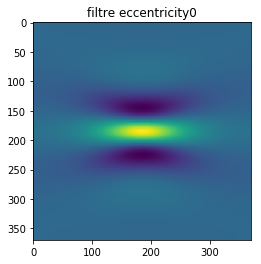

104.01223782585986
dimension_filtre 416
dimension_filtre 416
Pour i_eccentricity = 1  : x, y =  962 872
(416, 416)


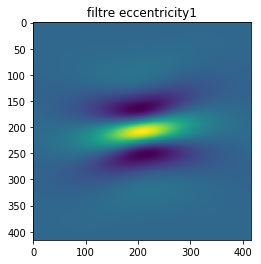

116.63372456638903
dimension_filtre 466
dimension_filtre 466
Pour i_eccentricity = 2  : x, y =  975 859
(466, 466)


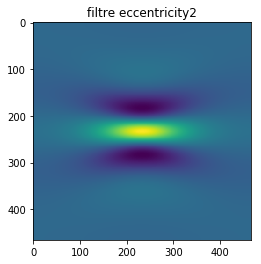

130.7867803883186
dimension_filtre 522
dimension_filtre 522
Pour i_eccentricity = 3  : x, y =  988 876
(522, 522)


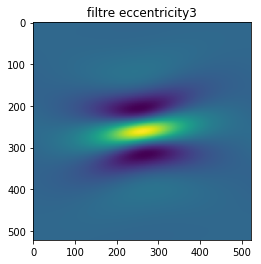

146.6572553344624
dimension_filtre 586
dimension_filtre 586
Pour i_eccentricity = 4  : x, y =  1005 859
(586, 586)


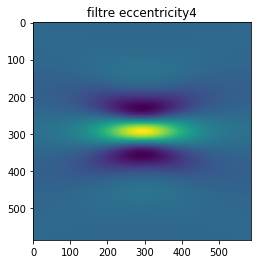

164.45355163860853
dimension_filtre 656
dimension_filtre 656
Pour i_eccentricity = 5  : x, y =  1022 880
(656, 656)


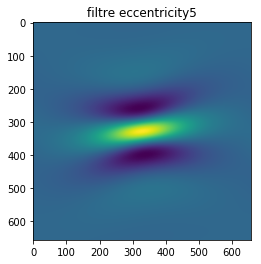

184.40936034752923
dimension_filtre 736
dimension_filtre 736
Pour i_eccentricity = 6  : x, y =  1043 859
(736, 736)


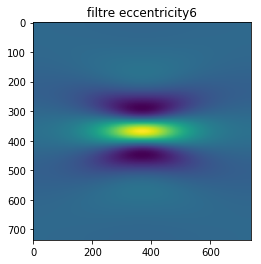

206.78673002159204
dimension_filtre 826
dimension_filtre 826
Pour i_eccentricity = 7  : x, y =  1064 885
(826, 826)


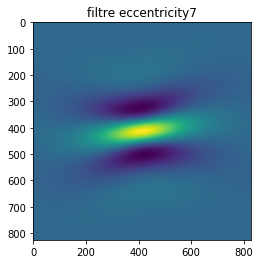

231.87950781043799
dimension_filtre 926
dimension_filtre 926
Pour i_eccentricity = 8  : x, y =  1090 859
(926, 926)


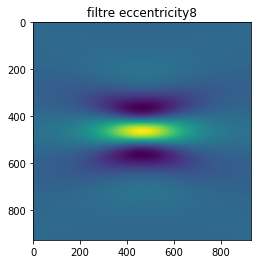

260.01719809001617
dimension_filtre 1040
dimension_filtre 1040
Pour i_eccentricity = 9  : x, y =  1116 892
(1040, 1040)


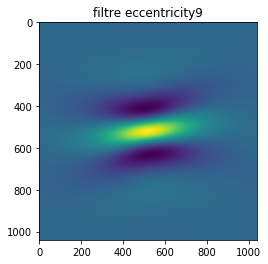

291.56928933044475
dimension_filtre 1166
dimension_filtre 1166
Pour i_eccentricity = 10  : x, y =  1150 859
(1166, 1166)


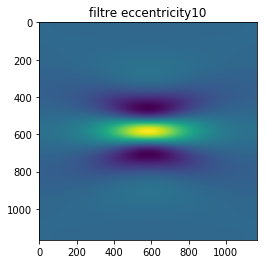

326.9501060127176
dimension_filtre 1306
dimension_filtre 1306
Pour i_eccentricity = 11  : x, y =  1183 901
(1306, 1306)


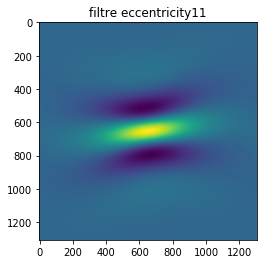

366.62424930692276
dimension_filtre 1466
dimension_filtre 1466
Pour i_eccentricity = 12  : x, y =  1225 859
(1466, 1466)


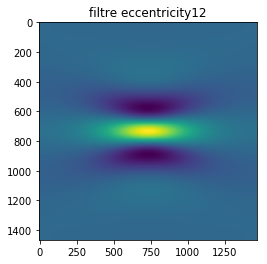

411.112697955927
dimension_filtre 1644
dimension_filtre 1644
Pour i_eccentricity = 13  : x, y =  1266 912
(1644, 1644)


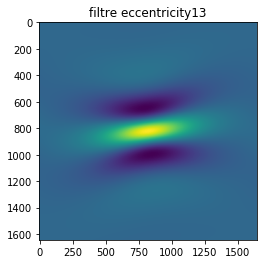

460.99964947793177
dimension_filtre 1718
dimension_filtre 1718
Pour i_eccentricity = 14  : x, y =  1319 859
(1718, 1718)


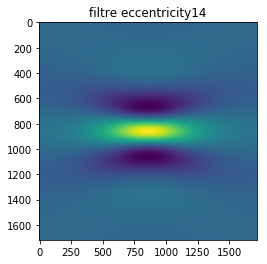

516.9401915227611
dimension_filtre 1718
dimension_filtre 1718
Pour i_eccentricity = 15  : x, y =  1371 926
(1718, 1718)


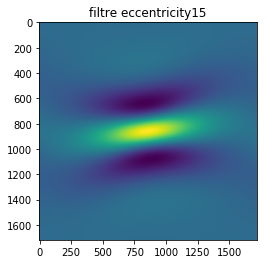

579.6689041178571
dimension_filtre 1718
dimension_filtre 1718
Pour i_eccentricity = 16  : x, y =  1438 859
(1718, 1718)


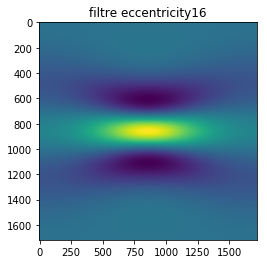

650.0095057638838
dimension_filtre 1718
dimension_filtre 1718
Pour i_eccentricity = 17  : x, y =  1503 943
(1718, 1718)


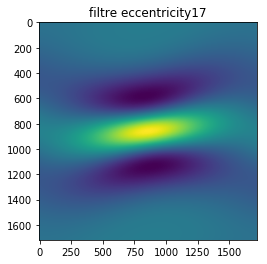

Dico cree
len finale 18


In [28]:
retina_dico = creation_retina_dico()
#print(type(retina_dico))